## **1 - Import de quelques librairies**

In [1]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from keras import callbacks
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D

## **2 - Montage du drive et import des donnees**

Montage du drive sur colab
Il est egalement possible de le faire automatiquement via le menu de gauche

Copie puis decompression du zip du dataset (environ 6 minutes)

Definition des repertoires :

In [2]:
repTrain  = 'train_images/'
repTest   = 'test_images/'

Premiere lecture du fichier train.csv :

In [3]:
train = pd.read_csv('train.csv')
train.head(5)

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


## **3 - Pre-traitement du dataset**

Separation nom de fichier / label

In [4]:
sep = '_'
train['image'] = train['Image_Label'].apply(lambda x: x.split(sep)[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split(sep)[1])
train = train.drop(['Image_Label'], axis=1)
train.head(5)

,EncodedPixels,image,label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,NaN,0011165.jpg,Gravel
3,NaN,0011165.jpg,Sugar
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


Suppression des labels sans zone identifiees (variable EncodedPixels a NaN)

In [5]:
train = train.dropna()
train.head(5)

,EncodedPixels,image,label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
7,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar


One Hot Encoding des classes de nuages et suprression des variables label et EncodedPixels

In [6]:
#On effectue une dichotomisation des classes de nuages
train_encoded = train
train_encoded= train_encoded.join(pd.get_dummies(train_encoded['label']))

#On supprime ensuite les colonnes "encoded Pixels" et "label", inutiles pour l'aggregation qui suit
train_encoded = train_encoded.drop(['EncodedPixels', 'label'], axis=1)

#Enfin on fait un sous-total pour ne conserver qu'une ligne par image
train_encoded = train_encoded.groupby(['image']).sum()

train_encoded = train_encoded.reset_index(level=0)
train_encoded.head()

,image,Fish,Flower,Gravel,Sugar
0,0011165.jpg,1,1,0,0
1,002be4f.jpg,1,1,0,1
2,0031ae9.jpg,1,1,0,1
3,0035239.jpg,0,1,1,0
4,003994e.jpg,1,0,1,1


On definit par ailleurs une liste des classes de nuages.

In [7]:
classes = ['Fish', 'Flower', 'Gravel', 'Sugar']

## **4 - Generateur et augmentation des images**

Via la methode ImageDataGenerator, nous allons definir un generateur qui va nous permettre d'appliquer un certain nombre de transformations a nos images.

La nature meme des images traitees (photos satellite de zone nuageuses) laissent une marge de manoeuvre relativement faible quant aux augmentations possibles. Nous avons opte pour les transformations suivantes :
- une normalisation
- des symetries horizontales et verticales
- des rotations aleatoires de l'ordre de 90 degres
- on peut egalement proceder a des glissements

Les images sont par ailleurs converties en nuances de gris par le generateur.
Enfin leur taille est divisee par 10.

A noter qu'en cas de transfert learning, la majorite des modeles veulent du rgb en entree (donc 3 canaux)

On choisit de positionner l'argument fill_mode a "constant" pour le vide soit comble par une couleur unie et non determine par le pixel le plus proche.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_width = 140
image_height = 210

datagen = ImageDataGenerator(rescale=1./255, 
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             fill_mode='constant',
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=.1,                             
                             validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_encoded,
    directory=repTrain,
    x_col='image',
    y_col=classes,
    subset='training',
    class_mode='raw',
    shuffle=True,                    #On melange tout
    color_mode="grayscale",          #On passe en nuance de gris
    target_size=(image_width, image_height),          #On divise la taille par 10
    batch_size=batch_size)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_encoded,
    directory=repTrain,
    x_col='image',
    y_col=classes,
    subset='validation',
    class_mode='raw',
    shuffle=True,
    color_mode="grayscale",
    target_size=(image_width, image_height),
    batch_size=batch_size)


Found 4437 validated image filenames.
Found 1109 validated image filenames.


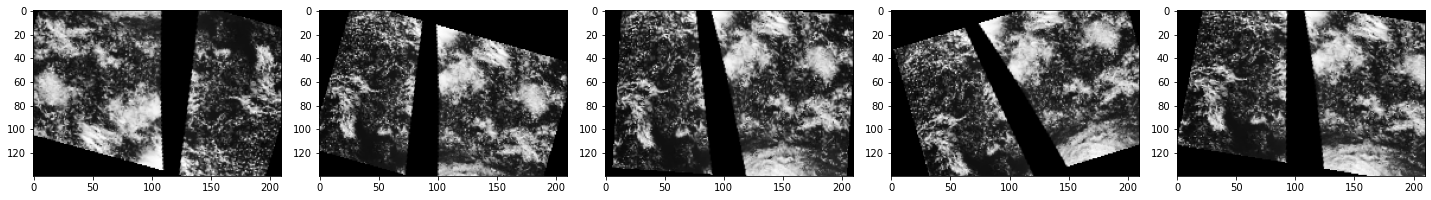

In [9]:
# On affiche la premiere image, qui peut changer a chaque execution puisque nous avons effectue un shuffle
# La premiere image est affichee ainsi que les augmentations qu'elle a subit
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):

        #Les images physiques sont en rgb mais en grayscale dans le generateur,
        #par consequent il faut repasser de 1 a 3 canaux
        stacked_img = np.squeeze(np.stack((img,) * 3, -1)) 
        ax.imshow(stacked_img, cmap='gray')
    plt.tight_layout()
    plt.show()


augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

## **5 - Etudes des convolutions et max-pooling sur les images**

Pour le fun, nous essyons de simuler ce que donne une convolution puis un max-pooling sur une image.

### **5.1 - Convolution**

(140, 210)


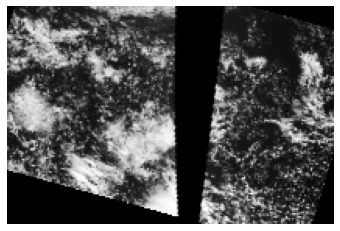

In [10]:
i = np.squeeze(np.stack((augmented_images[0],), -1)) 
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(i)
print(i.shape)


In [11]:
i_transformed = np.copy(i)
size_x = i_transformed.shape[0]
size_y = i_transformed.shape[1]

In [12]:
#On cree un filtre
filter = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
weight  = 1

In [13]:
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0
      convolution = convolution + (i[x - 1, y-1] * filter[0][0])
      convolution = convolution + (i[x, y-1] * filter[0][1])
      convolution = convolution + (i[x + 1, y-1] * filter[0][2])
      convolution = convolution + (i[x-1, y] * filter[1][0])
      convolution = convolution + (i[x, y] * filter[1][1])
      convolution = convolution + (i[x+1, y] * filter[1][2])
      convolution = convolution + (i[x-1, y+1] * filter[2][0])
      convolution = convolution + (i[x, y+1] * filter[2][1])
      convolution = convolution + (i[x+1, y+1] * filter[2][2])
      convolution = convolution * weight
      if(convolution<0):
        convolution=0
      if(convolution>255):
        convolution=255
      i_transformed[x, y] = convolution

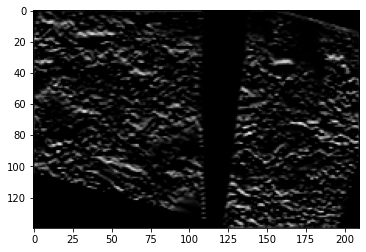

In [14]:
# Affichage de l'image qui a subit une convolution
plt.gray()
plt.grid(False)
plt.imshow(i_transformed)
plt.show() 

### **5.2 - Max-pooling**

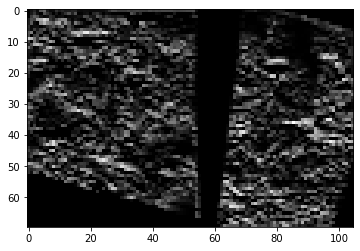

In [15]:
new_x = int(size_x/2)
new_y = int(size_y/2)
newImage = np.zeros((new_x, new_y))
for x in range(0, size_x, 2):
  for y in range(0, size_y, 2):
    pixels = []
    pixels.append(i_transformed[x, y])
    pixels.append(i_transformed[x+1, y])
    pixels.append(i_transformed[x, y+1])
    pixels.append(i_transformed[x+1, y+1])
    newImage[int(x/2),int(y/2)] = max(pixels)

#  Affichage de l'image qui a subit un max-pooling
# on peut remarquer que la taille a ete divisee par 2
plt.gray()
plt.grid(False)
plt.imshow(newImage)
plt.show()  

## **6 - Implementation d'un modele**

Voici un modele tres basic :
A noter que nous stipulons une fonction d'activation "sigmoid" pour les probablites d'apparenance aux 4 classes soient independantes les unes des autres. (ce qui n'est pas le cas de "softmax" par exemple).

In [16]:
model = Sequential()

model.add(Conv2D(64, (5,5), 
                 padding='valid', 
                 input_shape=(image_width, image_height,1), 
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5,5), 
                 padding='valid', 
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), 
                 padding='valid', 
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation = 'elu'))
model.add(Dropout(0.2))

model.add(Dense(254, activation = 'elu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 136, 206, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 103, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 99, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 22080)             0

Compilation du modele

In [17]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

Entrainment

In [18]:
EPOCHS = 20
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID)

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
138/138 [==============================] - 213s 2s/step - loss: 0.6818 - accuracy: 0.0959 - val_loss: 0.6750 - val_accuracy: 0.0809
Epoch 2/20
138/138 [==============================] - 204s 1s/step - loss: 0.6731 - accuracy: 0.1140 - val_loss: 0.6397 - val_accuracy: 0.0928
Epoch 3/20
138/138 [==============================] - 204s 1s/step - loss: 0.6300 - accuracy: 0.1820 - val_loss: 0.6227 - val_accuracy: 0.2739
Epoch 4/20
138/138 [==============================] - 204s 1s/step - loss: 0.6330 - accuracy: 0.2177 - val_loss: 0.6167 - val_accuracy: 0.2050
Epoch 5/20
138/138 [==============================] - 204s 1s/step - loss: 0.6100 - accuracy: 0.2079 - val_loss: 0.6086 - val_accuracy: 0.2987
Epoch 6/20
138/138 [==============================] - 205s 1s/step - loss: 0.6069 - accuracy: 0.2307 - val_loss: 0.5980 - val_accuracy: 0.2206
Epoch 7/20
138/138 [==============================] - 204s 1s/step - loss: 0.6126 - accuracy: 0.2286 - val_loss: 0.6029 - val_accuracy: 0.2822

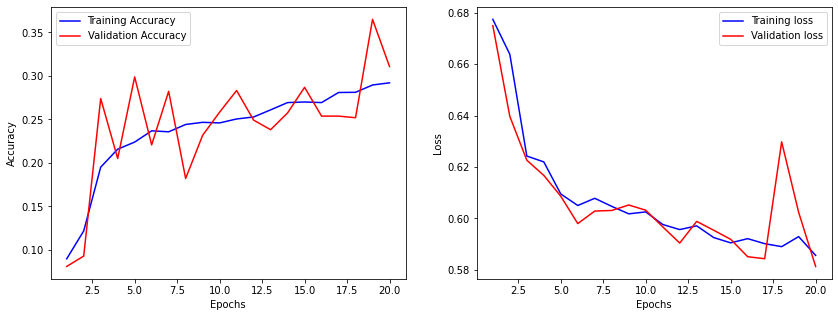

In [19]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
# Labels des axes
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         train_accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 21, 1),
         val_accuracy,
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         train_loss,
         label = 'Training loss',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 21, 1),
         val_loss,
         label = 'Validation loss',
         color = 'red')

# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

In [20]:
model = Sequential()

model.add(Conv2D(64, (5,5), 
                 padding='valid', 
                 input_shape=(image_width, image_height,1), 
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5,5), 
                 padding='valid', 
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), 
                 padding='valid', 
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), 
                 padding='valid', 
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, 
                activation = 'elu'))

model.add(Dense(128, 
                activation = 'elu'))

model.add(Dense(254, 
                activation = 'elu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 136, 206, 64)      1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 68, 103, 64)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 99, 128)       204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 49, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 47, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 23, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 21, 64)       

In [21]:
model.compile(optimizer=Adam(1.5e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
EPOCHS = 20
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID)

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
138/138 [==============================] - 235s 2s/step - loss: 0.6789 - accuracy: 0.0903 - val_loss: 0.6583 - val_accuracy: 0.2068
Epoch 2/20
138/138 [==============================] - 231s 2s/step - loss: 0.6497 - accuracy: 0.1633 - val_loss: 0.6240 - val_accuracy: 0.1903
Epoch 3/20
138/138 [==============================] - 232s 2s/step - loss: 0.6314 - accuracy: 0.1984 - val_loss: 0.6233 - val_accuracy: 0.1489
Epoch 4/20
138/138 [==============================] - 232s 2s/step - loss: 0.6219 - accuracy: 0.1903 - val_loss: 0.6358 - val_accuracy: 0.1673
Epoch 5/20
138/138 [==============================] - 231s 2s/step - loss: 0.6199 - accuracy: 0.2137 - val_loss: 0.6134 - val_accuracy: 0.2914
Epoch 6/20
138/138 [==============================] - 233s 2s/step - loss: 0.6096 - accuracy: 0.2840 - val_loss: 0.6265 - val_accuracy: 0.3290
Epoch 7/20
138/138 [==============================] - 238s 2s/step - loss: 0.6067 - accuracy: 0.2708 - val_loss: 0.5880 - val_accuracy: 0.2307

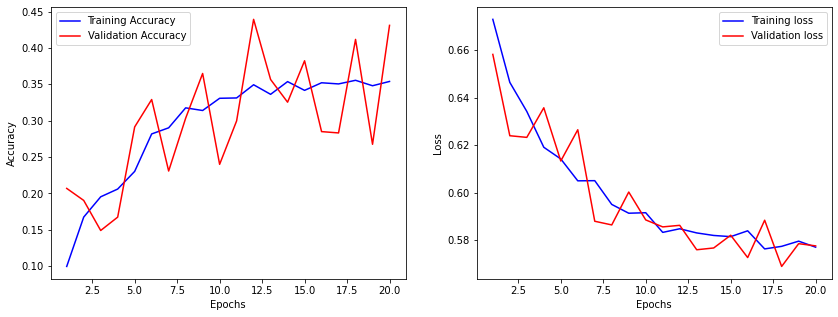

In [23]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
# Labels des axes
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         train_accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 21, 1),
         val_accuracy,
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         train_loss,
         label = 'Training loss',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 21, 1),
         val_loss,
         label = 'Validation loss',
         color = 'red')

# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

In [24]:
from tensorflow.keras import callbacks

checkpoint = callbacks.ModelCheckpoint(filepath='checkpoint',
                                       monitor='val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         verbose = 2,
                                         factor=0.5,
                                         mode = 'min')

e_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                     patience = 5,
                                     mode = 'min',
                                     restore_best_weights = True)



In [40]:
model = Sequential()

model.add(Conv2D(filters = 192,
                 kernel_size = (7,7),
                 input_shape=(image_width, image_height,1),
                 padding = 'valid',
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 256,
                 kernel_size = (3,3),
                 padding = 'valid',
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 512,
                 kernel_size = (3,3),
                 padding = 'valid',
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 1024,
                 kernel_size = (3,3),
                 padding = 'valid',
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 1024,
                 kernel_size = (3,3),
                 padding = 'valid',
                 activation = 'elu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024,
                activation = 'elu'))

model.add(Dense(4096,
                activation = 'elu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 134, 204, 192)     9600      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 67, 102, 192)      0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 65, 100, 256)      442624    
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 32, 50, 256)       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 30, 48, 512)       1180160   
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 15, 24, 512)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 13, 22, 1024)    

In [41]:
model.compile(optimizer=Adam(1.5e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
EPOCHS = 20
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[lr_plateau, checkpoint, e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
138/138 [==============================] - 532s 4s/step - loss: 0.6856 - accuracy: 0.1806 - val_loss: 0.6367 - val_accuracy: 0.2004
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/20
138/138 [==============================] - 531s 4s/step - loss: 0.6526 - accuracy: 0.1720 - val_loss: 0.6458 - val_accuracy: 0.1039
Epoch 3/20
138/138 [==============================] - 531s 4s/step - loss: 0.6363 - accuracy: 0.2040 - val_loss: 0.6167 - val_accuracy: 0.3061
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/20
138/138 [==============================] - 519s 4s/step - loss: 0.6274 - accuracy: 0.2592 - val_loss: 0.6089 - val_accuracy: 0.3392
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 5/20
138/138 [==============================] - 519s 4s/step - loss: 0.6177 - accuracy: 0.2977 - val_loss: 0.5994 - val_accuracy: 0.2491
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 6/20
138/138 [==============================] - 528s 4s/step - loss

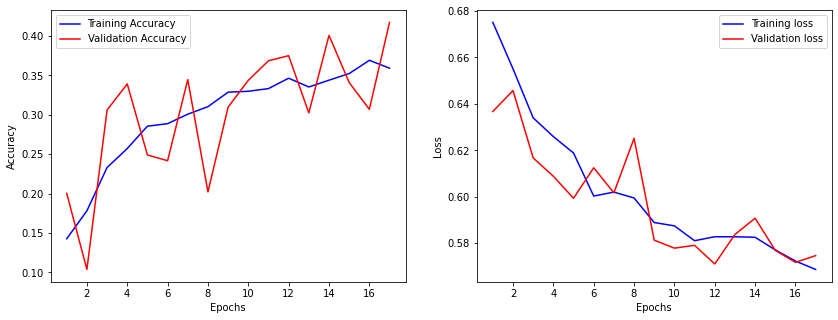

In [44]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
# Labels des axes
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 18, 1),
         train_accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 18, 1),
         val_accuracy,
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 18, 1),
         train_loss,
         label = 'Training loss',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 18, 1),
         val_loss,
         label = 'Validation loss',
         color = 'red')

# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

In [45]:
train_generator_color = datagen.flow_from_dataframe(
    dataframe=train_encoded,
    directory=repTrain,
    x_col='image',
    y_col=classes,
    subset='training',
    class_mode='raw',
    shuffle=True,                    #On melange tout
    #color_mode="grayscale",          #On passe en nuance de gris
    target_size=(image_width, image_height),          #On divise la taille par 10
    batch_size=batch_size)

validation_generator_color = datagen.flow_from_dataframe(
    dataframe=train_encoded,
    directory=repTrain,
    x_col='image',
    y_col=classes,
    subset='validation',
    class_mode='raw',
    shuffle=True,
    #color_mode="grayscale",
    target_size=(image_width, image_height),
    batch_size=batch_size)

Found 4437 validated image filenames.
Found 1109 validated image filenames.


In [46]:
from tensorflow.keras.applications import EfficientNetB1

efficientNet = EfficientNetB1(include_top=False,
                              input_shape=(image_width, image_height,3))
for layer in efficientNet.layers:
    layer.trainable = False

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 4, activation ='softmax'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 5, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 4)               

In [48]:
model.compile(loss = 'binary_crossentropy', 
              optimizer= Adam(1.5e-4), 
              metrics=['accuracy'])

In [49]:
EPOCHS = 20
STEP_SIZE_TRAIN=train_generator_color.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator_color.n//validation_generator.batch_size

history = model.fit_generator(
    train_generator_color,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator_color,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[lr_plateau, checkpoint, e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
138/138 [==============================] - 199s 1s/step - loss: 0.6852 - accuracy: 0.1001 - val_loss: 0.6730 - val_accuracy: 0.0772
Epoch 2/20
138/138 [==============================] - 189s 1s/step - loss: 0.6776 - accuracy: 0.0749 - val_loss: 0.6753 - val_accuracy: 0.0772
Epoch 3/20
138/138 [==============================] - 190s 1s/step - loss: 0.6775 - accuracy: 0.0764 - val_loss: 0.6723 - val_accuracy: 0.0781
Epoch 4/20
138/138 [==============================] - 196s 1s/step - loss: 0.6791 - accuracy: 0.0767 - val_loss: 0.6747 - val_accuracy: 0.0781
Epoch 5/20
138/138 [==============================] - 193s 1s/step - loss: 0.6790 - accuracy: 0.0823 - val_loss: 0.6715 - val_accuracy: 0.0781
Epoch 6/20
138/138 [==============================] - 190s 1s/step - loss: 0.6752 - accuracy: 0.0721 - val_loss: 0.6717 - val_accuracy: 0.0790
Epoch 7/20
138/138 [==============================] - 189s 1s/step - loss: 0.6772 - accuracy: 0.0828 - val_loss: 0.6728 - val_accuracy: 0.0772

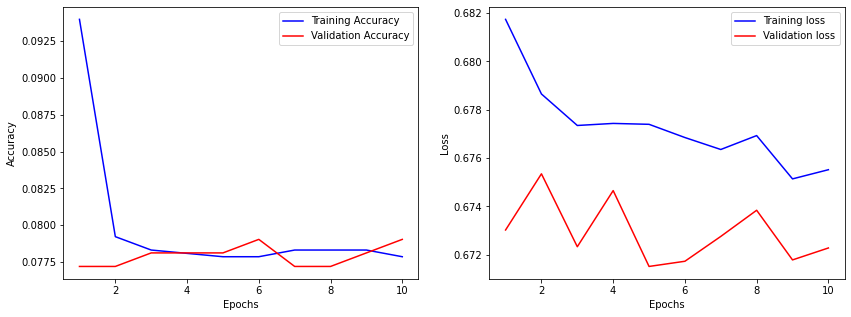

In [50]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
# Labels des axes
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 11, 1),
         train_accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 11, 1),
         val_accuracy,
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 11, 1),
         train_loss,
         label = 'Training loss',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 11, 1),
         val_loss,
         label = 'Validation loss',
         color = 'red')

# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

### Remarque:
- Les meilleurs résultats avec ces deux réseaux est 37.32% et 48.71%
- On a travaillé sur 4 classes, mais ne devrions nous pas essayer les 15 classes?

On reprends nos données et on prépare un jeux avec 15 classes

In [51]:
train_encoded.head()

,image,Fish,Flower,Gravel,Sugar
0,0011165.jpg,1,1,0,0
1,002be4f.jpg,1,1,0,1
2,0031ae9.jpg,1,1,0,1
3,0035239.jpg,0,1,1,0
4,003994e.jpg,1,0,1,1


In [52]:
train_encoded['classes']= train_encoded['Fish']*1000 + train_encoded['Flower']*100 + train_encoded['Gravel']*10 + train_encoded['Sugar']
train_encoded.head()

,image,Fish,Flower,Gravel,Sugar,classes
0,0011165.jpg,1,1,0,0,1100
1,002be4f.jpg,1,1,0,1,1101
2,0031ae9.jpg,1,1,0,1,1101
3,0035239.jpg,0,1,1,0,110
4,003994e.jpg,1,0,1,1,1011


In [53]:
train_encoded = train_encoded.drop(['Fish','Flower','Gravel','Sugar'], axis = 1)
train_encoded.head()

,image,classes
0,0011165.jpg,1100
1,002be4f.jpg,1101
2,0031ae9.jpg,1101
3,0035239.jpg,110
4,003994e.jpg,1011


In [54]:
train_encoded = train_encoded.join(pd.get_dummies(train_encoded['classes'], prefix='cl' ))
train_encoded.head()

,image,classes,cl_1,cl_10,cl_11,cl_100,cl_101,cl_110,cl_111,cl_1000,cl_1001,cl_1010,cl_1011,cl_1100,cl_1101,cl_1110,cl_1111
0,0011165.jpg,1100,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,002be4f.jpg,1101,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0031ae9.jpg,1101,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0035239.jpg,110,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,003994e.jpg,1011,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [55]:
train_encoded = train_encoded.drop('classes', axis = 1)
train_encoded.head()

,image,cl_1,cl_10,cl_11,cl_100,cl_101,cl_110,cl_111,cl_1000,cl_1001,cl_1010,cl_1011,cl_1100,cl_1101,cl_1110,cl_1111
0,0011165.jpg,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,002be4f.jpg,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0031ae9.jpg,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0035239.jpg,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,003994e.jpg,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [56]:
classes = ['cl_1','cl_10','cl_11','cl_100','cl_101','cl_110','cl_111','cl_1000',
           'cl_1001','cl_1010','cl_1011','cl_1100','cl_1101','cl_1110','cl_1111']

In [57]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_width = 140
image_height = 210

datagen = ImageDataGenerator(rescale=1./255, 
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             fill_mode='constant',
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=.1,                             
                             validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_encoded,
    directory=repTrain,
    x_col='image',
    y_col=classes,
    subset='training',
    class_mode='raw',
    shuffle=True,                    #On melange tout
    color_mode="grayscale",          #On passe en nuance de gris
    target_size=(image_width, image_height),          #On divise la taille par 10
    batch_size=batch_size)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_encoded,
    directory=repTrain,
    x_col='image',
    y_col=classes,
    subset='validation',
    class_mode='raw',
    shuffle=True,
    color_mode="grayscale",
    target_size=(image_width, image_height),
    batch_size=batch_size)

Found 4437 validated image filenames.
Found 1109 validated image filenames.


In [58]:
model15 = Sequential()

model15.add(Conv2D(64, (5,5), 
                   padding='valid', 
                   input_shape=(image_width, image_height,1), 
                   activation = 'elu'))
model15.add(MaxPooling2D(pool_size=(2, 2)))

model15.add(Conv2D(128, (5,5), 
                   padding='valid', 
                   activation = 'elu'))
model15.add(MaxPooling2D(pool_size=(2, 2)))

model15.add(Conv2D(128, (3,3), 
                   padding='valid', 
                   activation = 'elu'))
model15.add(MaxPooling2D(pool_size=(2, 2)))

model15.add(Conv2D(64, (3,3), 
                   padding='valid', 
                   activation = 'elu'))
model15.add(MaxPooling2D(pool_size=(2, 2)))

model15.add(Flatten())

model15.add(Dense(128, 
                  activation = 'elu'))
model15.add(Dense(128, 
                  activation = 'elu'))
model15.add(Dense(254, 
                  activation = 'elu'))
model15.add(Dropout(0.2))

model15.add(Dense(15, activation='sigmoid'))

In [59]:
model15.compile(optimizer=Adam(1.5e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
EPOCHS = 20
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model15.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID)

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
138/138 [==============================] - 235s 2s/step - loss: 0.3312 - accuracy: 0.0850 - val_loss: 0.2405 - val_accuracy: 0.1296
Epoch 2/20
138/138 [==============================] - 233s 2s/step - loss: 0.2464 - accuracy: 0.1076 - val_loss: 0.2388 - val_accuracy: 0.1443
Epoch 3/20
138/138 [==============================] - 232s 2s/step - loss: 0.2422 - accuracy: 0.1370 - val_loss: 0.2389 - val_accuracy: 0.1342
Epoch 4/20
138/138 [==============================] - 234s 2s/step - loss: 0.2424 - accuracy: 0.1352 - val_loss: 0.2369 - val_accuracy: 0.1544
Epoch 5/20
138/138 [==============================] - 232s 2s/step - loss: 0.2388 - accuracy: 0.1421 - val_loss: 0.2327 - val_accuracy: 0.1636
Epoch 6/20
138/138 [==============================] - 233s 2s/step - loss: 0.2326 - accuracy: 0.1783 - val_loss: 0.2356 - val_accuracy: 0.1664
Epoch 7/20
138/138 [==============================] - 233s 2s/step - loss: 0.2300 - accuracy: 0.1803 - val_loss: 0.2253 - val_accuracy: 0.1875

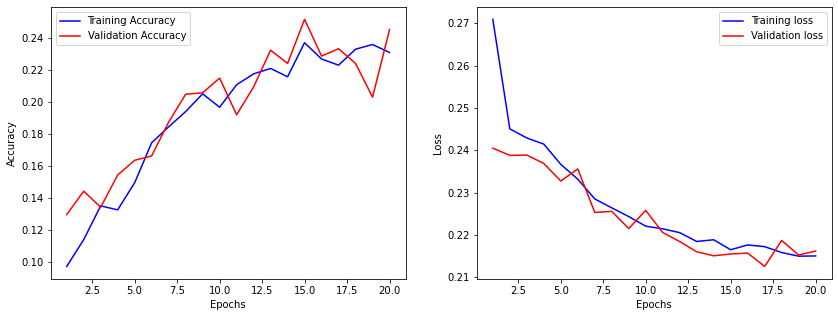

In [61]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
# Labels des axes
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         train_accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 21, 1),
         val_accuracy,
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         train_loss,
         label = 'Training loss',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 21, 1),
         val_loss,
         label = 'Validation loss',
         color = 'red')

# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

In [62]:
model15b = Sequential()

model15b.add(Conv2D(filters = 192,
                 kernel_size = (3,3),
                 padding = 'valid',
                 input_shape=(image_width, image_height,1),
                 activation = 'relu'))
model15b.add(MaxPooling2D(pool_size = (2,2)))

model15b.add(Conv2D(filters = 256,
                 kernel_size = (3,3),
                 padding = 'valid',
                 activation = 'relu'))
model15b.add(MaxPooling2D(pool_size = (2,2)))

model15b.add(Conv2D(filters = 512,
                 kernel_size = (3,3),
                 padding = 'valid',
                 activation = 'relu'))
model15b.add(MaxPooling2D(pool_size = (2,2)))

model15b.add(Conv2D(filters = 1024,
                 kernel_size = (3,3),
                 padding = 'valid',
                 activation = 'relu'))
model15b.add(MaxPooling2D(pool_size = (2,2)))

model15b.add(Conv2D(filters = 1024,
                 kernel_size = (3,3),
                 padding = 'valid',
                 activation = 'relu'))
model15b.add(MaxPooling2D(pool_size = (2,2)))

model15b.add(Flatten())

model15b.add(Dense(1024,
                activation = 'relu'))

model15b.add(Dense(4096,
                activation = 'relu'))
model15b.add(Dropout(0.2))

model15b.add(Dense(15, activation='sigmoid'))

model15b.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 138, 208, 192)     1920      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 69, 104, 192)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 67, 102, 256)      442624    
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 33, 51, 256)       0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 31, 49, 512)       1180160   
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 15, 24, 512)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 13, 22, 1024)    

In [63]:
model15b.compile(optimizer=Adam(1.5e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
EPOCHS = 20
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model15b.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID)

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
138/138 [==============================] - 503s 4s/step - loss: 0.3095 - accuracy: 0.1160 - val_loss: 0.2424 - val_accuracy: 0.1287
Epoch 2/20
138/138 [==============================] - 504s 4s/step - loss: 0.2426 - accuracy: 0.1347 - val_loss: 0.2430 - val_accuracy: 0.1232
Epoch 3/20
138/138 [==============================] - 503s 4s/step - loss: 0.2395 - accuracy: 0.1328 - val_loss: 0.2404 - val_accuracy: 0.1296
Epoch 4/20
138/138 [==============================] - 502s 4s/step - loss: 0.2399 - accuracy: 0.1343 - val_loss: 0.2393 - val_accuracy: 0.1287
Epoch 5/20
138/138 [==============================] - 503s 4s/step - loss: 0.2396 - accuracy: 0.1367 - val_loss: 0.2396 - val_accuracy: 0.1241
Epoch 6/20
138/138 [==============================] - 503s 4s/step - loss: 0.2398 - accuracy: 0.1270 - val_loss: 0.2390 - val_accuracy: 0.1278
Epoch 7/20
138/138 [==============================] - 503s 4s/step - loss: 0.2385 - accuracy: 0.1409 - val_loss: 0.2395 - val_accuracy: 0.1498

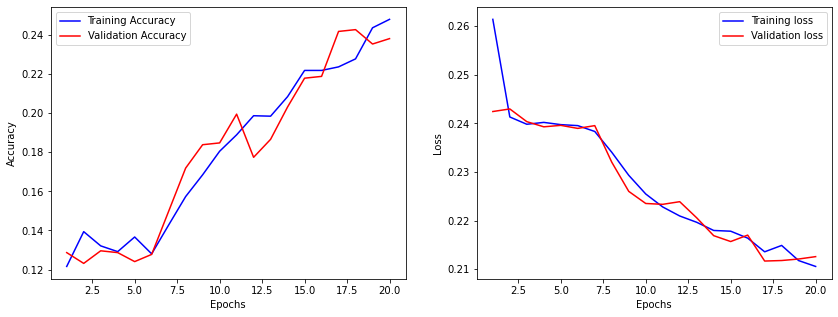

In [65]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
# Labels des axes
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         train_accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 21, 1),
         val_accuracy,
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         train_loss,
         label = 'Training loss',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 21, 1),
         val_loss,
         label = 'Validation loss',
         color = 'red')

# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()